In [1]:
import pickle
import numpy as np
from PIL import Image
import skimage as ski
import sys, time
import geopandas as gpd
from matplotlib import pyplot as plt

sys.path.insert(0, "/home/adriano/projeto_mestrado/modules")

from Funcoes_gerais import funcoes

import background_generation as backgen

root_dir = f"/home/adriano/projeto_mestrado/modules"

img_dir = f'{root_dir}/Imagens/vessel_data/images/'
lab_dir = f'{root_dir}/Imagens/vessel_data/labels_20x/'
pickle_dir = f'{root_dir}/Vessel_Models_pickle'
background_dir = f'{root_dir}/Background/Mapas_gerados_artificialmente'
tracados_dir = f'{root_dir}/Artificial_Lines/tracados_bezier'
#img_especifica = 'Experiment #1 (adults set #1)_20x_batch1 - Superficial layers@40-Image 3-20X'

array_pickles = funcoes.ler_diretorios(pickle_dir)
array_backgrounds = funcoes.ler_diretorios(background_dir)
array_tracados = funcoes.ler_diretorios(tracados_dir)

n_backgrounds = np.random.randint(0, len(array_backgrounds))
n_tracados = np.random.randint(0, len(array_tracados))
tracado = array_tracados[n_tracados]

array_medial_path = backgen.retorna_paths(f'{tracados_dir}/{tracado}')

#back_artif = np.array(Image.open(root_dir + f'/Background/Mapas_gerados_artificialmente/{img_especifica}.tiff'))
back_artif = np.array(Image.open(f'{background_dir}/{array_backgrounds[n_backgrounds]}'))

vetor_informacoes = []
vetor_mapas_sem_artefatos = []
vetor_mapas_originais = []
vetor_vasos_sem_artefados = []
vetor_mask_map = []
vetor_mapas_originais_norm = []
vetor_mapas_originais_merge_norm_random = []
vetor_limiares1 = []
vetor_limiares2 = []

for i in range(len(array_medial_path)):
#for i in range(1):  
  n_random = np.random.randint(0, len(array_pickles)) 
  
  ti = time.time()
  path = (pickle_dir + f'/{array_pickles[n_random]}')
  print('lendo o pickle: ', time.time()-ti)

  arquivo_pickle = pickle.load(open(path, 'rb')) 
  vessel_map = arquivo_pickle['vessel_model'].vessel_map 
  mapa_original = vessel_map.mapped_values
  
  imagem_binaria_original = vessel_map.mapped_mask_values
  
  
  ti = time.time()
  imagem_binaria_sem_artefatos_laterais = backgen.retornar_imagem_binaria_sem_artefatos(vessel_map, imagem_binaria_original)
  print('imagem_binaria_sem_artefatos_laterais: ', time.time()-ti)

  ti = time.time()
  imagem_binaria_sem_artefatos = backgen.fill_holes(imagem_binaria_sem_artefatos_laterais)
  print('imagem_binaria_sem_artefatos: ', time.time()-ti)

  ti = time.time()
  mapa_original_norm = backgen.normaliza(back_artif,mapa_original,imagem_binaria_sem_artefatos)
  print('mapa_original_norm: ', time.time()-ti)

  #mapa_original_merge_norm_random = backgen.merge(back_artif,mapa_original,imagem_binaria_sem_artefatos, p=0.5)  

  rows, cols = mapa_original.shape  

  ti = time.time()
  limiar1 = backgen.encontrar_pixel_mais_frequente(mapa_original_norm)
  print('limiar1: ', time.time()-ti)
  
  ti = time.time()
  limiar2 = backgen.encontrar_mediana_fundo_mapa(mapa_original_norm,imagem_binaria_sem_artefatos)
  print('limiar2: ', time.time()-ti)

  distancia = (rows/2) 
  

  ti = time.time()
  caminhos_transladados = backgen.retorna_caminhos_transladados(array_medial_path[i],0) # type: ignore
  print('retorna_caminhos_transladados: ', time.time()-ti)

  maior_valor = np.max(caminhos_transladados[0])

  ti = time.time()
  mapa_expandido_original = backgen.expandir_mapas_do_tamanho_do_tracado(mapa_original_norm,maior_valor)
  print('expandir_mapas_do_tamanho_do_tracado_mapa_original: ', time.time()-ti) 

  ti = time.time()
  vaso_expandido_bin = backgen.expandir_mapas_do_tamanho_do_tracado(imagem_binaria_sem_artefatos,maior_valor)
  print('expandir_mapas_do_tamanho_do_tracado_binario: ', time.time()-ti)  
 
  dict = {
      "path": path,
      "arquivo_pickle": arquivo_pickle,
      "vessel_map": vessel_map,
      "mapa_original": mapa_original,
      "imagem_binaria_original": imagem_binaria_original,
      "imagem_binaria_sem_artefatos_laterais": imagem_binaria_sem_artefatos_laterais,  
      "imagem_binaria_sem_artefatos": imagem_binaria_sem_artefatos,
      "mapa_original_norm": mapa_original_norm,
      #"mapa_original_merge_norm_random" : mapa_original_merge_norm_random,
      "caminhos_transladados": caminhos_transladados,
      "maior_valor": maior_valor,
      "mapa_expandido_original": mapa_expandido_original,
      "vaso_expandido_bin": vaso_expandido_bin,
      "rows": rows,
      "cols": cols,
      "distancia": distancia,
      "limiar1": limiar1,
      "limiar2": limiar2
    }
  vetor_informacoes.append(dict)

for i in range(len(array_medial_path)): 

    caminhos_transladados = vetor_informacoes[i]['caminhos_transladados'] # type: ignore
    maior_valor = vetor_informacoes[i]['maior_valor'] # type: ignore
    distancia = vetor_informacoes[i]['distancia'] # type: ignore
    mapa_original = vetor_informacoes[i]['mapa_original'] # type: ignore
    mapa_original_norm = vetor_informacoes[i]['mapa_original_norm'] # type: ignore
    #mapa_original_merge_norm_random = vetor_informacoes[i]['mapa_original_merge_norm_random'] # type: ignore    
    imagem_binaria_sem_artefatos = vetor_informacoes[i]['imagem_binaria_sem_artefatos'] # type: ignore
    mapa_expandido_original = vetor_informacoes[i]['mapa_expandido_original'] # type: ignore
    vaso_expandido_bin = vetor_informacoes[i]['vaso_expandido_bin'] # type: ignore     
    vessel_map = vetor_informacoes[i]['vessel_map'] # type: ignore
    limiar1 = vetor_informacoes[i]['limiar1'] # type: ignore 
    limiar2 = vetor_informacoes[i]['limiar2'] # type: ignore 

    ti = time.time()
    linha_offset_esquerda, linha_central,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(array_medial_path[i],distancia)
    print('retorna_linhas_offset_posicao_tamanho: ', time.time()-ti)

    ti = time.time()
    dst_array_np = backgen.retorna_dst_array_np(linha_offset_esquerda, linha_central,linha_offset_direita, maior_tamanho)
    print('retorna_dst_array_np: ', time.time()-ti)

    ti = time.time()
    img_proper, img_out, new_src, new_dst, tform_out, translation, new_origin = backgen.rotacionando_mapa_expandido(mapa_expandido_original,dst_array_np,maior_tamanho)
    print('rotacionando_mapa_expandido: ', time.time()-ti)

    ti = time.time()
    mask_map = backgen.criar_mascara_binaria_mapa(new_dst,img_out)
    print('criar_mascara_binaria_mapa: ', time.time()-ti)

    ti = time.time()
    mask_vaso = backgen.criar_mascara_binaria_vaso(vessel_map,new_origin,array_medial_path[i],img_out)
    print('criar_mascara_binaria_vaso: ', time.time()-ti)

    ti = time.time()
    vaso_binario_rotacionado = backgen.criar_vaso_binario_expandido(vaso_expandido_bin,dst_array_np,maior_tamanho)
    print('criar_vaso_binario_expandido: ', time.time()-ti)

    ti = time.time()
    mapa_sem_artefatos = backgen.retirar_artefatos(img_out,mask_map)
    print('retirar_artefatos_mapa: ', time.time()-ti)

    ti = time.time()
    img_out_bin = backgen.criar_vaso_binario_expandido(vaso_expandido_bin,dst_array_np,maior_tamanho)
    print('criar_vaso_binario_expandido: ', time.time()-ti)

    ti = time.time()
    vaso_sem_artefatos = backgen.retirar_artefatos(img_out_bin,mask_vaso)   
    print('retirar_artefatos_vaso: ', time.time()-ti)

    vetor_vasos_sem_artefados.append(vaso_sem_artefatos)
    vetor_mapas_sem_artefatos.append(mapa_sem_artefatos)
    vetor_mask_map.append(mask_map)
    vetor_mapas_originais.append(mapa_original)
    vetor_mapas_originais_norm.append(mapa_original_norm)
    #vetor_mapas_originais_merge_norm_random.append(mapa_original_merge_norm_random)
    vetor_limiares1.append(limiar1)
    vetor_limiares2.append(limiar2)

lendo o pickle:  4.0531158447265625e-06
imagem_binaria_sem_artefatos_laterais:  0.00024080276489257812
imagem_binaria_sem_artefatos:  0.0005075931549072266
mapa_original_norm:  0.0070760250091552734
limiar1:  0.0001544952392578125
limiar2:  0.0007402896881103516
retorna_caminhos_transladados:  0.0001747608184814453
expandir_mapas_do_tamanho_do_tracado_mapa_original:  4.76837158203125e-06
expandir_mapas_do_tamanho_do_tracado_binario:  1.9073486328125e-06
lendo o pickle:  1.1920928955078125e-06
imagem_binaria_sem_artefatos_laterais:  0.00011396408081054688
imagem_binaria_sem_artefatos:  0.00023937225341796875
mapa_original_norm:  0.00547337532043457
limiar1:  0.00019097328186035156
limiar2:  0.00015997886657714844
retorna_caminhos_transladados:  0.00020837783813476562
expandir_mapas_do_tamanho_do_tracado_mapa_original:  5.9604644775390625e-06
expandir_mapas_do_tamanho_do_tracado_binario:  1.9073486328125e-06
lendo o pickle:  2.6226043701171875e-06
imagem_binaria_sem_artefatos_laterais:  

/tmp/ipykernel_1928/2268152027.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(vetor_mapas_sem_artefatos),i+1)
/tmp/ipykernel_1928/2268152027.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(vetor_mapas_originais_norm),i+1)
/tmp/ipykernel_1928/2268152027.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(vetor_mapas_originais),i+1)


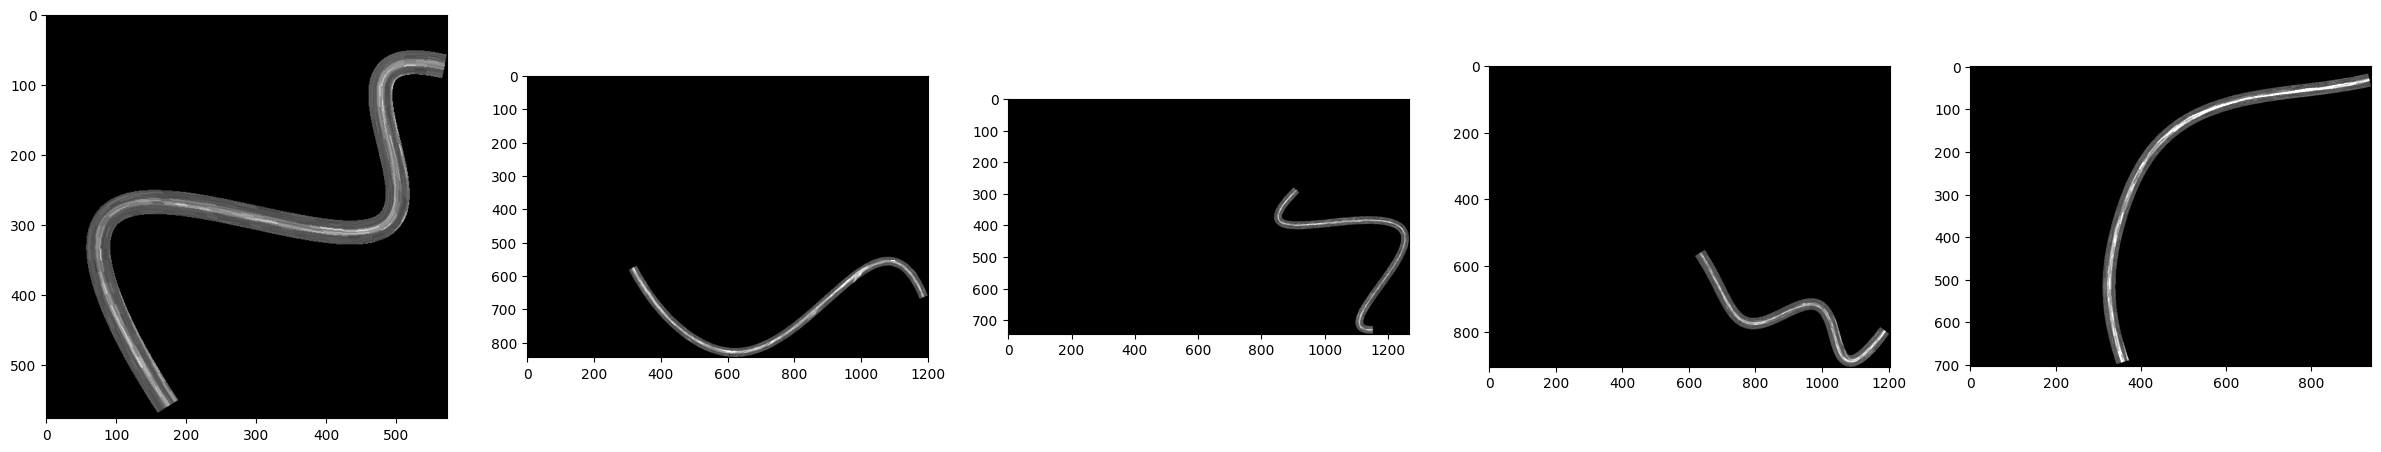

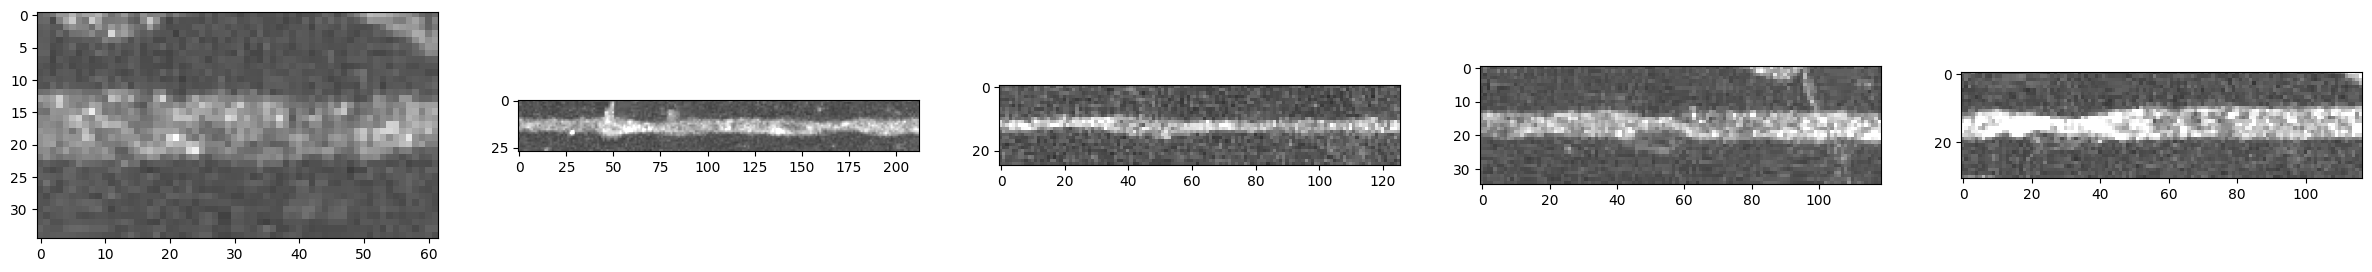

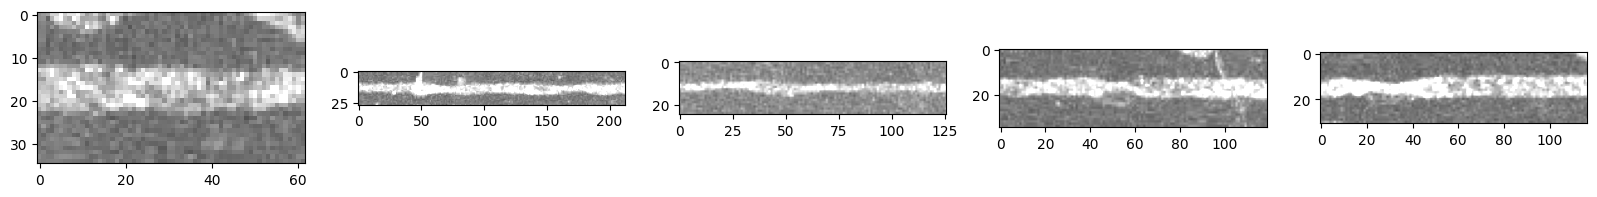

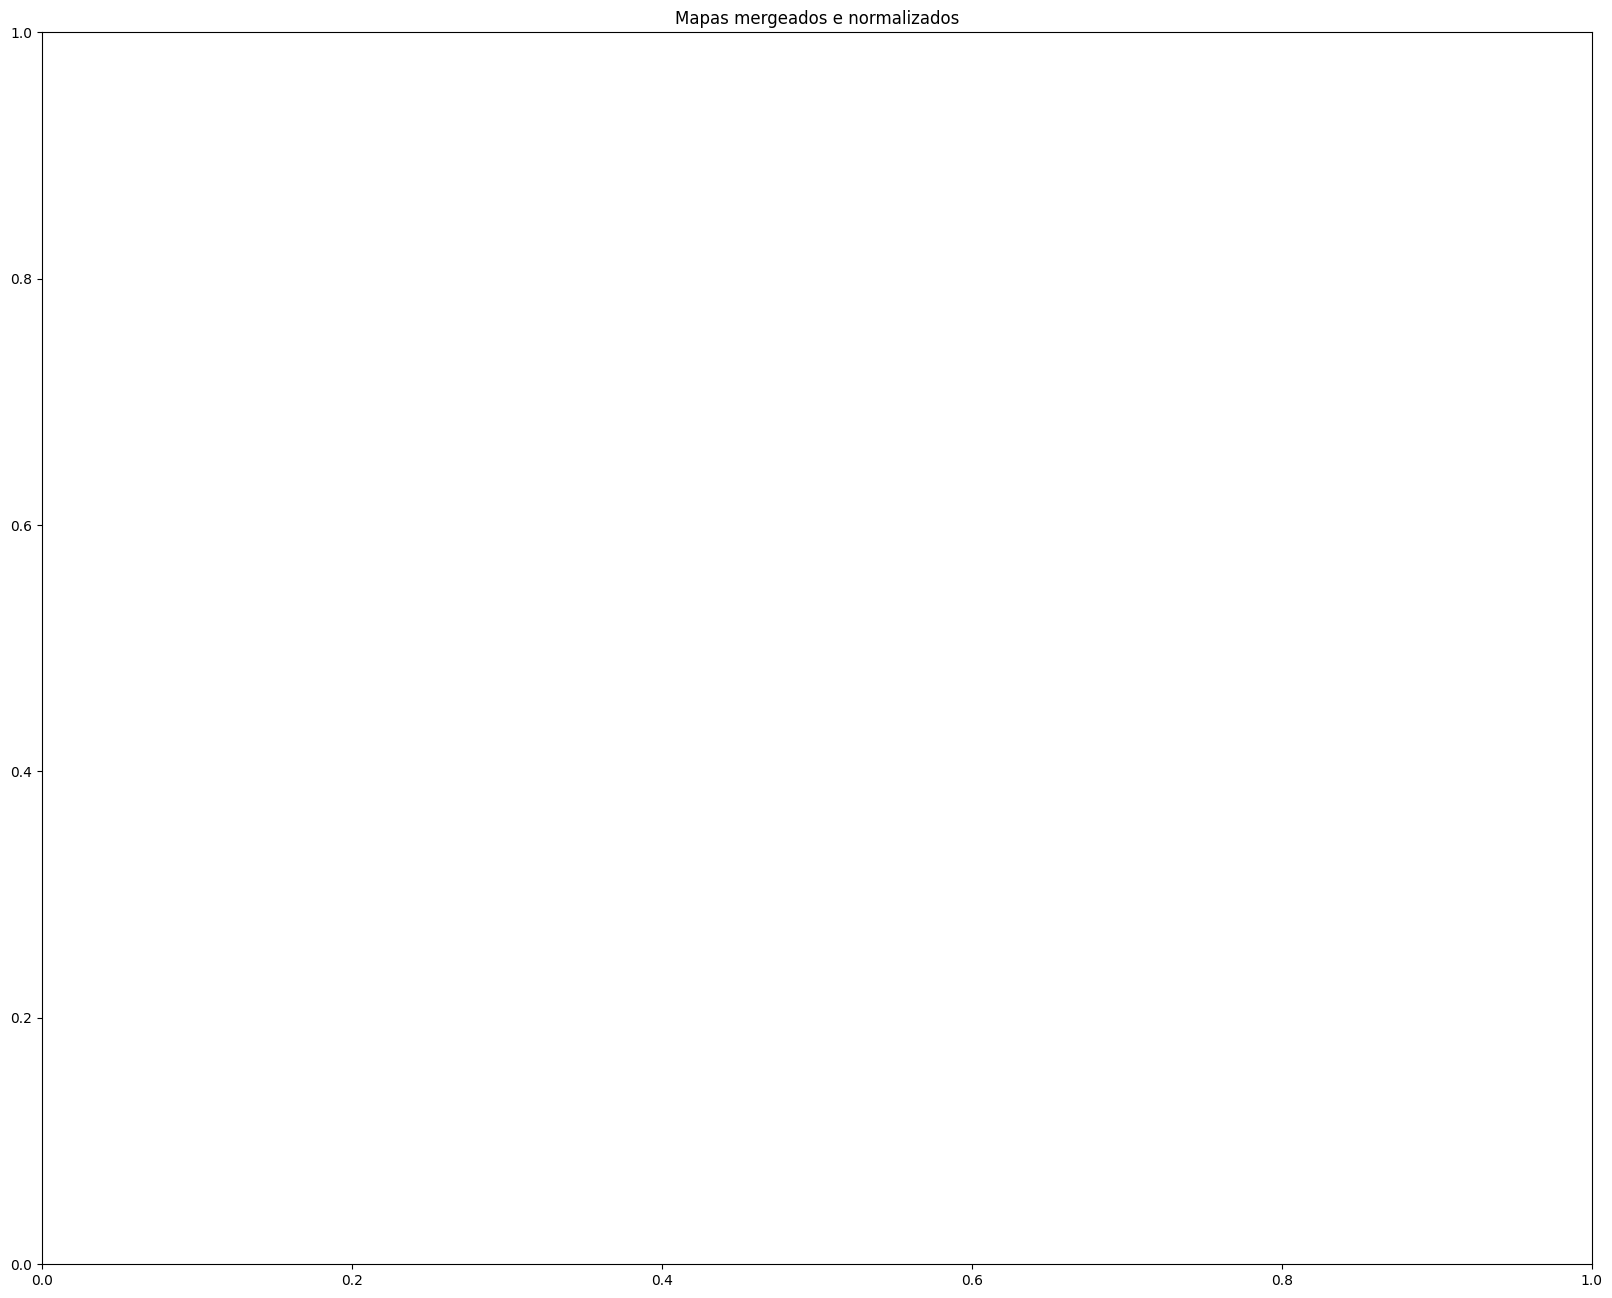

In [2]:

# plt.figure(figsize=[10, 8])
# plt.title("fundo com vaso")
# plt.imshow(img, 'gray', vmin=0, vmax=60)
# plt.plot()

plt.figure(figsize=[30, 30])
plt.title("mapa_sem_artefatos")
for i in range(len(vetor_mapas_sem_artefatos)):  
    plt.subplot(1,len(vetor_mapas_sem_artefatos),i+1)  
    plt.imshow(vetor_mapas_sem_artefatos[i], 'gray', vmin=0, vmax=60)

plt.figure(figsize=[30, 30])
plt.title("Mapas normalizados")
for i in range(len(vetor_mapas_originais_norm)):  
    plt.subplot(1,len(vetor_mapas_originais_norm),i+1)  
    plt.imshow(vetor_mapas_originais_norm[i], 'gray', vmin=0, vmax=60)

plt.figure(figsize=[20, 16])
plt.title("Mapas originais")
for i in range(len(vetor_mapas_originais)):  
    plt.subplot(1,len(vetor_mapas_originais),i+1)  
    plt.imshow(vetor_mapas_originais[i], 'gray', vmin=0, vmax=60)

plt.figure(figsize=[20, 16])
plt.title("Mapas mergeados e normalizados")
for i in range(len(vetor_mapas_originais_merge_norm_random)):  
    plt.subplot(1,len(vetor_mapas_originais_merge_norm_random),i+1)  
    plt.imshow(vetor_mapas_originais_merge_norm_random[i], 'gray', vmin=0, vmax=60)



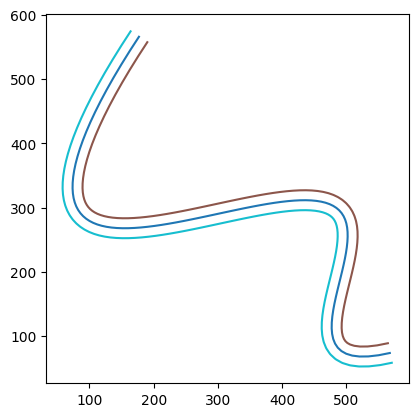

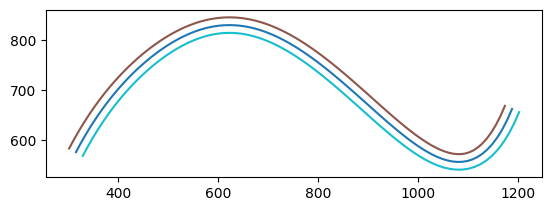

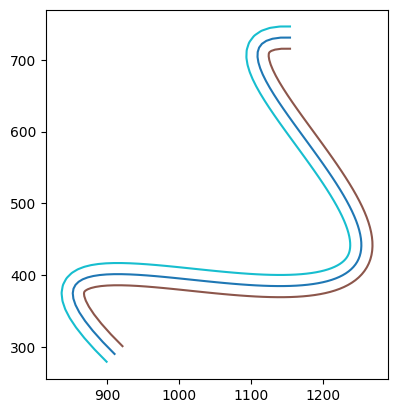

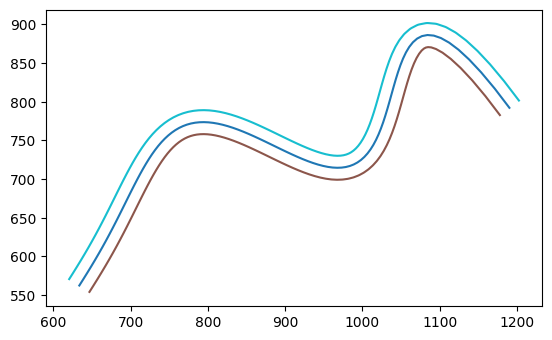

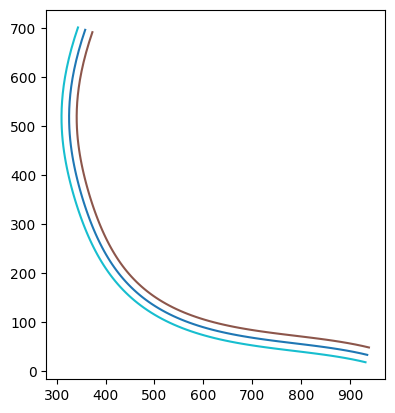

In [3]:
for i in range(len(array_medial_path)):    
    #caminhos_transladados_interpolado = backgen.retorna_caminhos_transladados(array_medial_path[i], 2) # type: ignore

    linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(array_medial_path[i],distancia)

    gp4 = gpd.GeoSeries([linha_offset_esquerda, linha_central, linha_offset_direita])
    gp4.plot(cmap="tab10")

[]

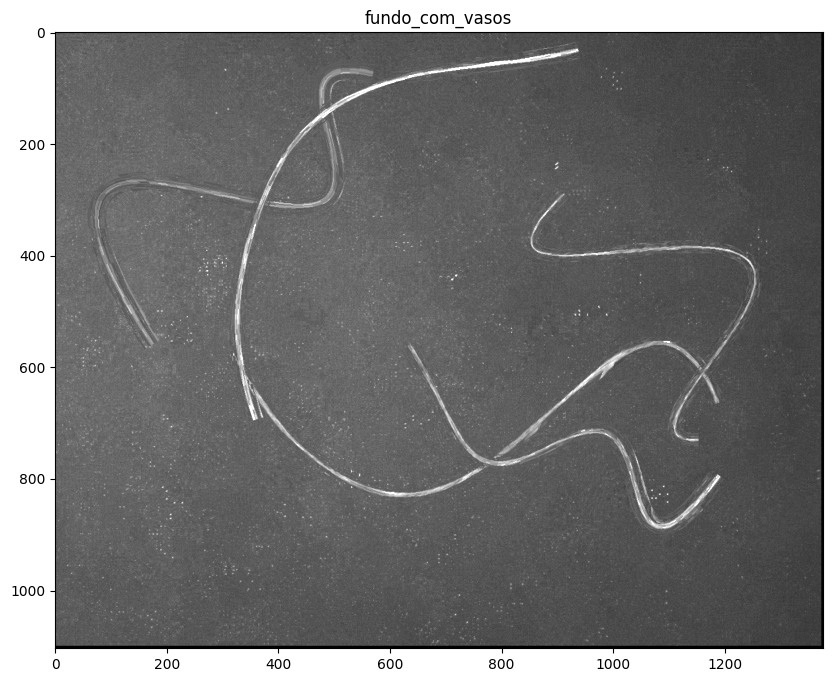

In [4]:
 
#back_artif = np.array(Image.open(f'{background_dir}/{array_backgrounds[1]}'))


fundo_com_vasos = back_artif.copy()
for i in range(5):   
    fundo_com_vasos = backgen.inserindo_vaso_fundo2(vetor_mapas_sem_artefatos[i], vetor_vasos_sem_artefados[i], fundo_com_vasos, (0,0), vetor_limiares2[i])  



plt.figure(figsize=[10, 8])
plt.title("fundo_com_vasos")
plt.imshow(fundo_com_vasos, 'gray', vmin=0, vmax=60)
plt.plot()



In [5]:
print(vetor_limiares1)
print(vetor_limiares2)

[19, 19, 20, 19, 19]
[20.323159653234914, 20.53288120777546, 20.756962911609172, 20.469778021323418, 20.60103906259081]


In [6]:
# for i in range(len(array_backgrounds)):
#    back_artif = np.array(Image.open(f'{background_dir}/{array_backgrounds[i]}'))
#    plt.figure(figsize=[10, 8])
#    plt.title("img_mapa_norm")
#    plt.imshow(back_artif, 'gray', vmin=0, vmax=60)
#    plt.plot()
